> 参考: https://www.wakari.io/sharing/bundle/Pandas4Finance/09_Portfolios?has_login=False

In [1]:
# various pandas, numpy
import pandas as pd
import numpy as np
import scipy as sp
import scipy.optimize as scopt
import copy

# for csv data
import requests
from io import StringIO

# plotting
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.charts import TimeSeries, Line, Donut, Bar
from bokeh.models import HoverTool

In [2]:
def get_funds_daiwa_close_data(url):
    res = requests.get(url)
    res.encoding = 'sjis'
    df = pd.read_csv(StringIO(res.text))
    df.index = pd.to_datetime(df['基準日'].map(str))
    df.index.name = 'Date'
    return df['分配金再投資基準価額']

In [3]:
# http://www.daiwa-am.co.jp/funds/dc/index.html
# DCダイワ物価連動国債ファンド
jgb = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=3717&type=1')
# ダイワ投信倶楽部外国債券インデックス
bond_w = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=5833&type=1')
# ダイワ投信倶楽部日本債券インデックス
bond_jp = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=5831&type=1')
# DC・ダイワ・トピックス・インデックス(確定拠出年金専用ファンド)
stock_jp = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=5842&type=1')
# ダイワ投信倶楽部外国株式インデックス
stock_w = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=5832&type=1')
# DC・ダイワＪ－REITオープン
reit_jp = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=3712&type=1')
# DCダイワ・グローバルREITインデックスファンド
reit_w = get_funds_daiwa_close_data('http://www.daiwa-am.co.jp/funds/detail/csv_out.php?code=3716&type=1')

In [4]:
# http://www.smtam.jp/fund/detail/_id_112/
# SMTAMダウ・ジョーンズ インデックスファンド
res = requests.get('http://www.smtam.jp/fund_data/csv/110046.csv')
res.encoding = 'sjis'
df = pd.read_csv(StringIO(res.text))
df.index = pd.to_datetime(df['基準日'])
df.index.name = 'Date'
stock_us = df['基準価額'] + df['分配金']

In [5]:
closes = pd.DataFrame(
    [jgb, bond_jp, stock_jp, bond_w, stock_w, stock_us, reit_jp, reit_w]).T
closes.columns = ['jgb', 'bond_jp', 'stock_jp', 'bond_w', 'stock_w',
                  'stock_us', 'reit_jp', 'reit_w']
closes = closes.loc['2010':'2016']

In [6]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))

In [7]:
# calculate daily returns
daily_returns = calc_daily_returns(closes).dropna()
daily_returns.head()

,jgb,bond_jp,stock_jp,bond_w,stock_w,stock_us,reit_jp,reit_w
Date,,,,,,,,
2010-01-05,0.005088,-0.000177,0.004097,-0.000221,0.011820,0.008368,0.004601,-0.005260
2010-01-06,0.001014,-0.000619,0.012503,-0.010090,-0.007386,-0.008857,-0.007097,-0.002779
2010-01-07,-0.000101,-0.000886,0.000828,0.010421,0.012595,0.009019,-0.007777,0.006519
2010-01-08,-0.001928,-0.000620,0.010088,0.006540,0.009051,0.013657,-0.001891,0.012912
2010-01-12,-0.003154,0.000443,0.014035,-0.001755,-0.002578,-0.006163,0.007416,-0.006985


In [8]:
cum_returns = (daily_returns + 1).cumprod() - 1

In [9]:
cum_returns.tail()

,jgb,bond_jp,stock_jp,bond_w,stock_w,stock_us,reit_jp,reit_w
Date,,,,,,,,
2016-12-26,0.206544,0.134387,0.593330,0.284751,0.836920,1.380299,1.293516,1.005716
2016-12-27,0.206544,0.134652,0.591160,0.289652,0.843463,1.389054,1.300452,1.012659
2016-12-28,0.207053,0.133857,0.593869,0.292957,0.850836,1.394965,1.317419,1.020795
2016-12-29,0.207053,0.135092,0.574501,0.286536,0.832328,1.371605,1.322231,0.999340
2016-12-30,0.207053,0.135357,0.574772,0.288403,0.826075,1.355723,1.344420,1.010578


In [10]:
p = TimeSeries(cum_returns, plot_width=600, plot_height=400, ylabel='return')
output_notebook()
show(p)

Loading BokehJS ...

/home/driller/jupyter5/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [11]:
# calculate annual returns
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(lambda date: date.year).sum()) - 1
    return grouped

In [12]:
annual_returns = calc_annual_returns(daily_returns)
annual_returns

,jgb,bond_jp,stock_jp,bond_w,stock_w,stock_us,reit_jp,reit_w
2010,0.045904,0.020962,-0.004632,-0.132962,-0.026423,-0.006363,0.306369,0.046797
2011,0.038038,0.013861,-0.175145,0.008778,-0.099062,0.030378,-0.224120,-0.031122
2012,0.059100,0.012646,0.200282,0.191047,0.290839,0.210677,0.393261,0.345311
2013,0.038325,0.014767,0.532849,0.214134,0.525406,0.558576,0.395234,0.216613
2014,0.024351,0.037003,0.095129,0.161587,0.221071,0.271948,0.283021,0.415052
2015,-0.002502,0.005773,0.113720,-0.051837,-0.021243,-0.002158,-0.055369,0.001587
2016,-0.008864,0.025114,-0.004285,-0.044378,0.021296,0.099248,0.092280,-0.016018


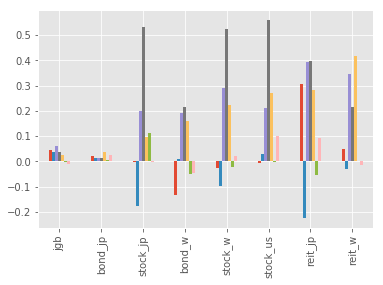

In [13]:
plt.style.use('ggplot')
annual_returns.T.plot(kind='bar', legend=None, figsize=(6, 4))
plt.show()

In [14]:
def calc_portfolio_var(returns, weights=None):
    if weights is None:
        weights = np.ones(returns.columns.size) / returns.columns.size
    sigma = np.cov(returns.T, ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [15]:
# calculate our portfolio variance (equal weighted)
calc_portfolio_var(annual_returns)

0.015834510329725108

In [16]:
def sharpe_ratio(returns, weights=None, risk_free_rate=0.001):
    n = returns.columns.size
    if weights is None: weights = np.ones(n) / n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    return (means.dot(weights) - risk_free_rate) / np.sqrt(var)

In [17]:
# calculate equal weighted sharpe ratio
sharpe_ratio(annual_returns)

0.79693898716672773

In [18]:
def negative_sharpe_ratio_n_minus_1_stock(weights, returns, risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1 - np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [19]:
def optimize_portfolio(returns, risk_free_rate):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(
        returns.columns.size - 1, dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(
        negative_sharpe_ratio_n_minus_1_stock,
        w0,
        args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [20]:
# optimize our portfolio
optimize_result = optimize_portfolio(annual_returns, 0.001)

Optimization terminated successfully.
         Current function value: -0.929498
         Iterations: 296
         Function evaluations: 454


In [21]:
optimize_result

(array([ 0.155745  ,  0.58719646,  0.03377363,  0.02491247,  0.03596304,
         0.054105  ,  0.05181253,  0.05649187]), 0.92949803794541552)

In [22]:
pie_data = {'data': optimize_result[0], 'label': list(daily_returns.columns)}
p = Donut(pie_data, values='data', label='label')
show(p)

In [23]:
non_optimize_cum_returns = cum_returns.apply(sum, axis=1)
optimize_cum_returns = (cum_returns * optimize_result[0] *
                        len(cum_returns.columns)).apply(
                            sum, axis=1)

df = pd.DataFrame([non_optimize_cum_returns, optimize_cum_returns]).T
df.columns = ['non_optimize', 'optimize']

In [24]:
p = TimeSeries(df, ylabel='return', plot_width = 600, plot_height = 400)
show(p)

In [25]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R, axis=0)
    port_mean = np.dot(W, stock_mean)  # portfolio mean
    cov = np.cov(R.T)  # var-cov matrix
    port_var = np.dot(np.dot(W, cov), W.T)  # portfolio variance
    penalty = 2000 * abs(port_mean - target_ret)  # penalty 4 deviation
    return np.sqrt(port_var) + penalty  # objective function

In [26]:
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []

    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()

    nstocks = returns.columns.size

    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks) / nstocks
        bounds = [(0, 1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(
            objfun,
            weights, (returns, r),
            method='SLSQP',
            constraints=constraints,
            bounds=bounds)
        if not results.success:  # handle error
            raise Exception(result.message)
        result_means.append(np.round(r, 4))  # 4 decimal places
        std_ = np.round(np.std(np.sum(returns * results.x, axis=1)), 6)
        result_stds.append(std_)

        result_weights.append(np.round(results.x, 5))
    return {
        'Means': result_means,
        'Stds': result_stds,
        'Weights': result_weights
    }

In [27]:
# calculate our frontier
frontier_data = calc_efficient_frontier(annual_returns)
# first five risk levels
frontier_data['Stds'][:5]

[0.0094400000000000005,
 0.0084089999999999998,
 0.0087480000000000006,
 0.0098659999999999998,
 0.011117]

In [28]:
# first five mean returns
frontier_data['Means'][:5]

[0.018599999999999998,
 0.0201,
 0.021700000000000001,
 0.023199999999999998,
 0.0247]

In [29]:
# first five sets of optimal weights
frontier_data['Weights'][:5]

[array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.13711,  0.85986,  0.00304,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ]),
 array([ 0.20004,  0.7863 ,  0.01366,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ]),
 array([ 0.23787,  0.74171,  0.01043,  0.     ,  0.     ,  0.00999,
         0.     ,  0.     ]),
 array([ 0.24951,  0.72397,  0.00134,  0.     ,  0.     ,  0.02517,
         0.     ,  0.     ])]

In [30]:
frontier_data2 = copy.deepcopy(frontier_data)
frontier_data2['Weights'] = [', '.join(
    ['{}: {:.2%}'.format(*d) for d in list(zip(daily_returns.columns, x))])
    for x in frontier_data['Weights']]

source = ColumnDataSource(frontier_data2)
hover = HoverTool(tooltips=[("Weights", "@Weights"), ])
p = figure(plot_width=600, plot_height=400, tools=[hover],
           title="Efficient Frontier")
p.circle('Stds', 'Means', source=source)
p.xaxis.axis_label = "Stds"
p.yaxis.axis_label = "Means"

show(p)